In [1]:
import sys
sys.path.insert(0, '../scripts/')

from __init__ import *

from scipy import sparse
import collections
import itertools
import re
import seaborn as sns 
import matplotlib.pyplot as plt

import basic_utils
import clst_utils
import SCF_utils

## Loading configurations  

In [2]:
log = basic_utils.create_logger()
logging.info('*')

11/25/2020 04:00:33 PM *


In [3]:
config_dir = './' 
config_f = 'config_scf.py' 
sys.path.insert(0, config_dir)
exec("from {} import *".format(config_f.split('.')[0]))

sys.path.insert(0, DATA_DIR)
import __init__datasets

In [4]:
print(output_clst_and_umap)
print(output_figures)

./results/intg_summary_test_scf_mouse_mop.tsv
./results/test_scf_mouse_mop_{}.{}


## Read in data and integration results

In [5]:
# dataset-specific metadata
metas = collections.OrderedDict()
for mod in mods_selected:
    meta = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)
    meta = meta.astype(dtype={settings[mod].annot_col: str})
    metas[mod] = meta
    print(mod, metas[mod].shape)

snmcseq_gene (298, 32)
smarter_cells (13, 129)
smarter_nuclei (195, 146)
10x_cells_v2 (525, 8)


In [6]:
# integration results
mods_ordered = mods_selected  # could order datasets differently than specified by mods_selected

assert set(mods_ordered) == set(mods_selected)

f = output_clst_and_umap
df_info = pd.read_csv(f, sep="\t", index_col='sample') 
df_info = df_info.rename({
                          'tsne_x': 'umap_x_joint',
                          'tsne_y': 'umap_y_joint',
                         }, axis=1)
df_info['modality_name'] = df_info['modality'].apply(lambda mod: settings[mod].name)

# add single-modality cluster, annot info
df_info['cluster'] = ''
df_info['annot'] = ''
for mod in mods_selected:
    _cells = metas[mod].index.values
    df_info.loc[_cells, 'cluster'] = metas[mod].loc[_cells, settings[mod].cluster_col]
    df_info.loc[_cells, 'annot'] = metas[mod].loc[_cells, settings[mod].annot_col]

# clean up annotation
df_info['annot'] = df_info['annot'].fillna(df_info['cluster'])

# get info
print(df_info.shape)
print(df_info.groupby('modality').size())
df_info.head()

(1031, 10)
modality
10x_cells_v2      525
smarter_cells      13
smarter_nuclei    195
snmcseq_gene      298
dtype: int64


,cluster_joint_r0.1,cluster_joint_r0.2,cluster_joint_r0.4,cluster_joint_r0.8,umap_x_joint,umap_y_joint,modality,modality_name,cluster,annot
sample,,,,,,,,,,
snmcseq_gene_2C_M_1054,2,3,3,3,1.859907,5.577936,snmcseq_gene,DNA methylation,L5-PT-Bcl6,L5-PT-Bcl6
snmcseq_gene_2C_M_106,2,3,3,3,3.201965,4.340900,snmcseq_gene,DNA methylation,L5-PT-Bcl6,L5-PT-Bcl6
snmcseq_gene_2C_M_1076,2,3,3,3,3.469238,5.335502,snmcseq_gene,DNA methylation,L5-PT-Bcl6,L5-PT-Bcl6
snmcseq_gene_2C_M_1078,2,2,2,1,3.951146,1.590831,snmcseq_gene,DNA methylation,L5-PT-Bcl6,L5-PT-Bcl6
snmcseq_gene_2C_M_1110,2,2,2,1,6.178766,0.078904,snmcseq_gene,DNA methylation,L5-PT-Bcl6,L5-PT-Bcl6


## Making plots

In [7]:
### organizing data

joint_cluster = 'cluster_joint_r0.4' # choose a joint cluster to visualize

# mod colors and names
mod_colors = collections.OrderedDict({mod: settings[mod].color for mod in mods_ordered})
mod_names = {mod: settings[mod].name for mod in mods_ordered}

# get cluster centroids
centroids = {}
_x = (df_info[['umap_x_joint', 'umap_y_joint', 'annot', 'modality']]
             .groupby(['modality', 'annot']).median())
for mod in mods_selected:
    centroids[mod] = _x.loc[mod, :]
centroids['joint'] = (df_info[['umap_x_joint', 'umap_y_joint', joint_cluster]]
             .groupby([joint_cluster]).median())

# get annotation for joint clusters 
joint_annot = df_info[df_info['modality'].isin(features_selected)].groupby([joint_cluster]).agg({'annot': lambda x: x.value_counts().index.values[0]})

# get uniq colors for joint clusters  
clsts = np.sort(df_info[joint_cluster].unique())
colors = basic_utils.gen_colors(len(clsts))
joint_clst_colors = {clst: color for clst, color in zip(clsts, colors)}

# histograms
hist = df_info.groupby([joint_cluster, 'modality']).size().unstack().fillna(0).astype(int)
hist_mod = hist.sum(axis=0)
hist_clst = hist.sum(axis=1)

hist_frac = hist.divide(hist_clst, axis=0)
hist_exp = pd.DataFrame(np.outer(hist_clst/hist_clst.sum(), hist_mod), 
             index=hist_clst.index, columns=hist_mod.index.values)
hist_enrich = (hist+1)/(hist_exp+1)

11/25/2020 04:00:33 PM Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
11/25/2020 04:00:33 PM NumExpr defaulting to 8 threads.


#### plot1: integrated embedding colored by data modality and by clusterings with different resolutions

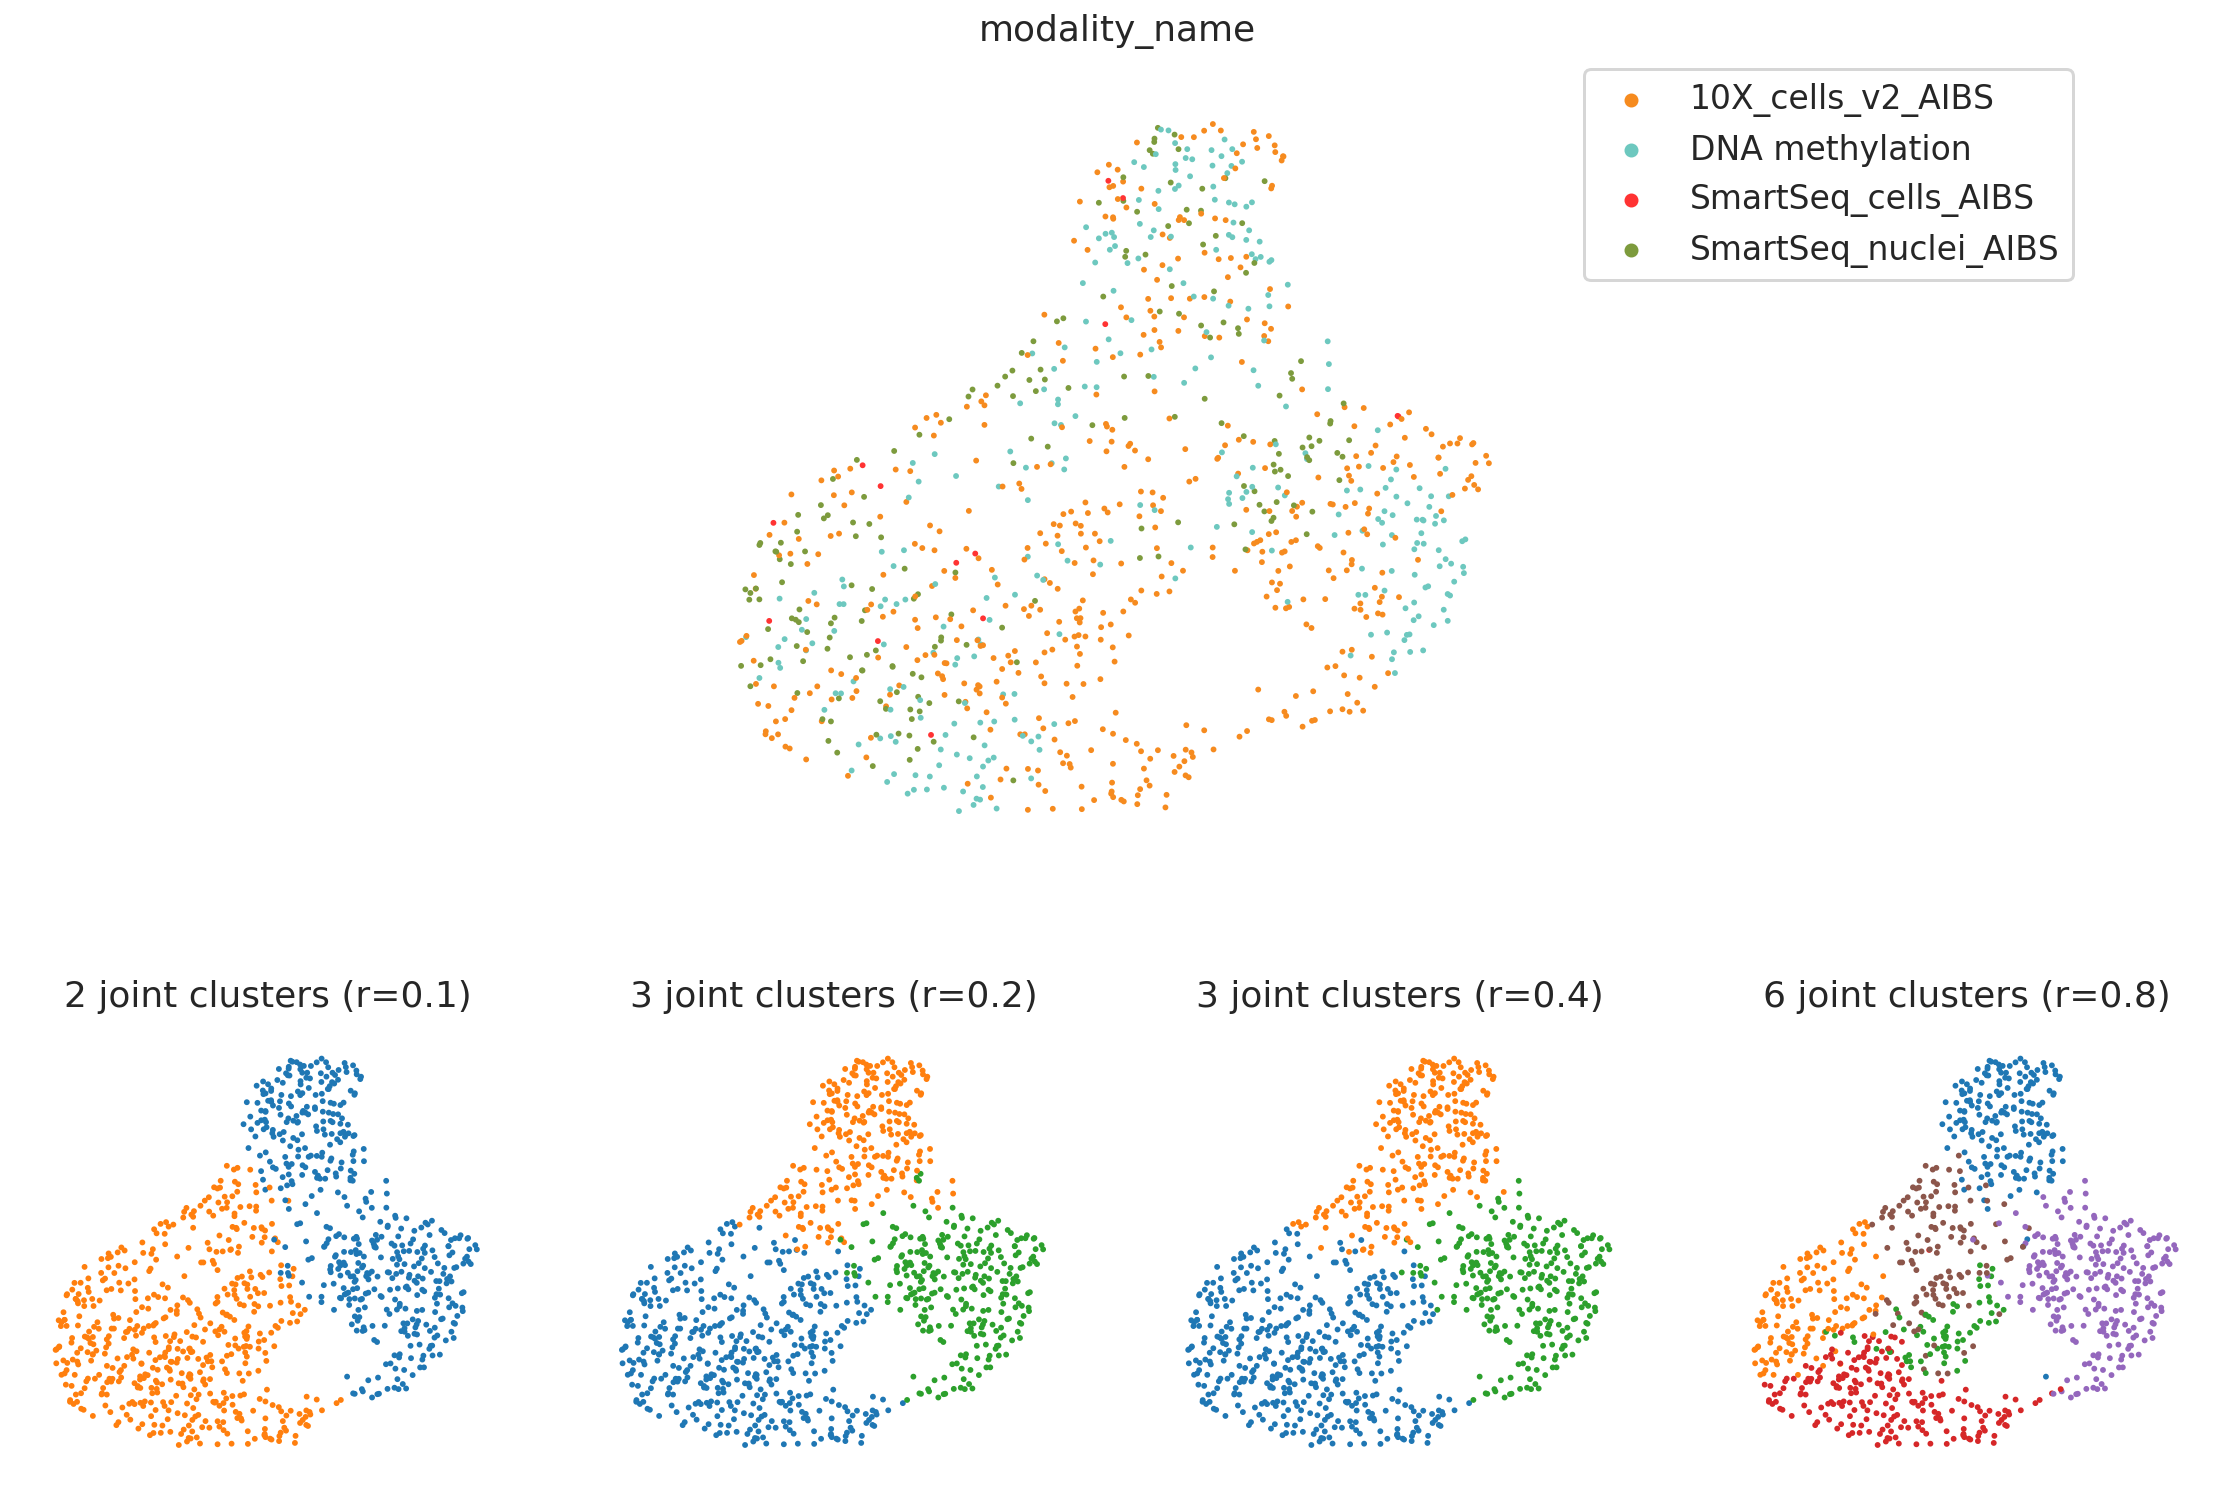

In [8]:
from matplotlib.gridspec import GridSpec
sample_n = min(len(df_info), 20000)
n_resolutions = len(resolutions)
fig = plt.figure(figsize=(8*2,6*2))
gs = GridSpec(2, n_resolutions)

ax = fig.add_subplot(gs[0, :])
kw_colors = {settings[mod].name: settings[mod].color for mod in mods_ordered}
tx, ty, tc = 'umap_x_joint', 'umap_y_joint', 'modality_name'
legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
basic_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                  legend_kws=legend_kws,
                                  kw_colors=kw_colors,
                                  sample_n=sample_n,
                                  legend_size=30,
                                  rasterized=True,
                                  s=2,
                                 )
ax.set_aspect('equal')
ax.axis('off')

layouts = [(1, i) for i in range(n_resolutions)]
for resolution, layout in zip(resolutions, layouts):
    ax = fig.add_subplot(gs[layout[0], layout[1]])
    tx, ty, tc = 'umap_x_joint', 'umap_y_joint', 'cluster_joint_r{}'.format(resolution)
    basic_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                      legend_mode=-1,
                                      sample_n=sample_n,
                                      rasterized=True,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('{} joint clusters (r={})'.format(len(df_info[tc].unique()), resolution))

fig.tight_layout()
fig.savefig(output_figures.format('plot_1_joint_embedding_and_clusterings_overview', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

#### plot2: histograms--number and fraction of cells from each data modality for each integrated cluster 

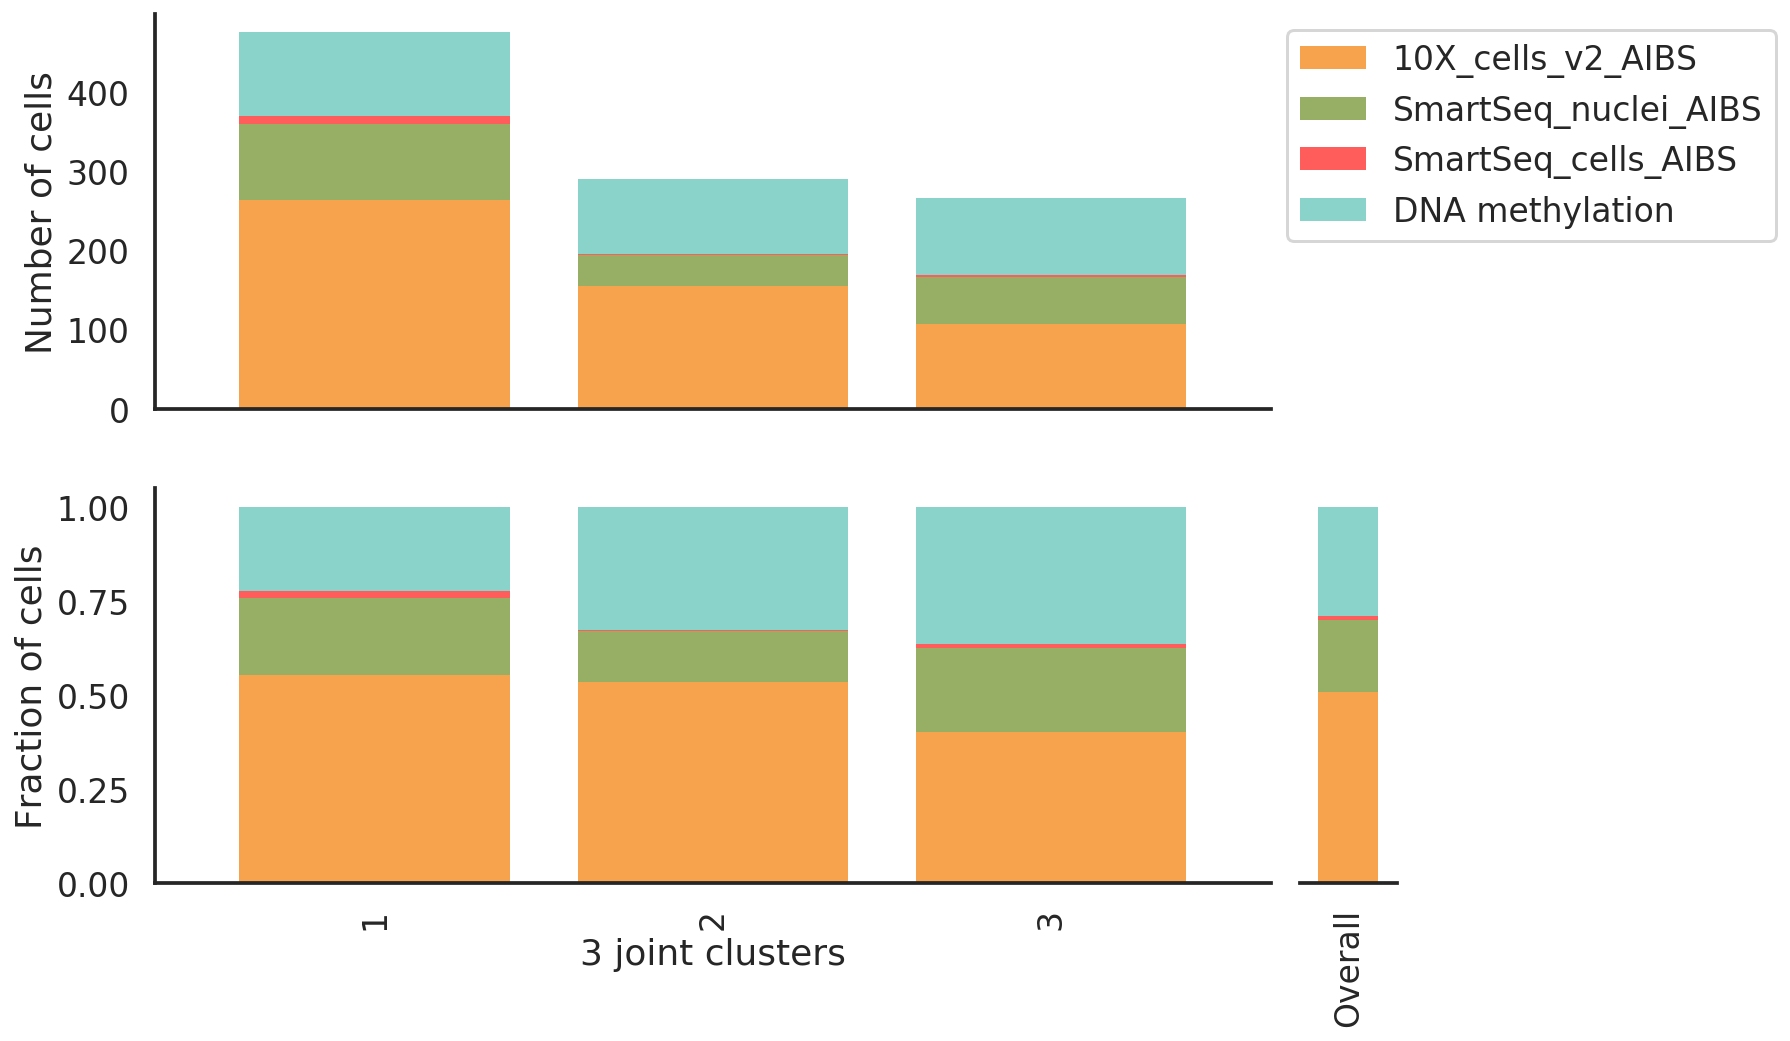

In [9]:

# histograms
with sns.axes_style('white', {"patch.edgecolor": "black", 'patch.force_edgecolor': False,}):
    fig, axs = plt.subplots(2, 1, figsize=(10,4*2))
    ax = axs[0]
    hist[mods_ordered[::-1]].rename(index=mod_names, columns=mod_names).plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, 
                  color=[val for key, val in mod_colors.items()][::-1], # this controls mod_colors
                 )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_ylabel('Number of cells')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    

    ax = axs[1]
    hist_frac[mods_ordered[::-1]].rename(index=mod_names, columns=mod_names).plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                  color=[val for key, val in mod_colors.items()][::-1], # this controls mod_colors
                 )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('Fraction of cells')
    ax.set_xlabel('{} joint clusters'.format(len(hist)))
#     ax.set_xticklabels([])
    
#     ax = fig.add_axes([.95, .5, .05, .4])
    left_x, left_y, width, height = ax.get_position().bounds
    ax = fig.add_axes((left_x+width+0.2*(1-(left_x+width)), left_y, 0.3*(1-width), height))
    ((hist_mod/hist_mod.sum()).loc[mods_ordered[::-1]].to_frame().T.rename({0: 'Overall'}, axis=0)
                      .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                      color=[val for key, val in mod_colors.items()][::-1]) # this controls mod_colors
    )
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
#     fig.tight_layout()
    fig.savefig(output_figures.format('plot_2_hist', 'pdf'), bbox_inches='tight')
    plt.show()

#### plot3: integrated embedding colored by data modality separately

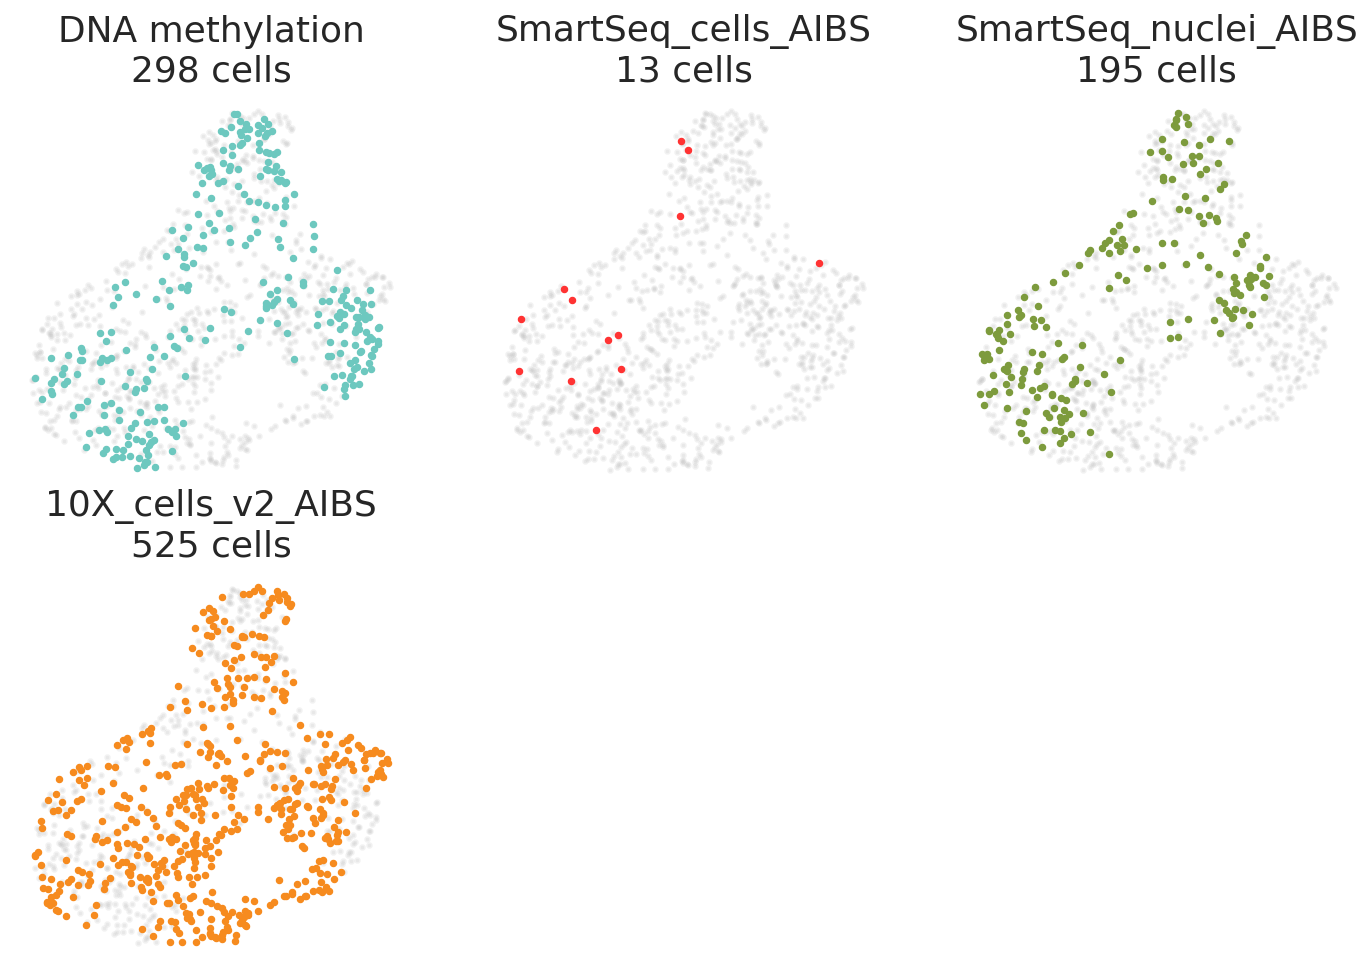

In [10]:
n = len(mods_selected)
nx = 3
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))
axs = axs.flatten()
for mod, ax in zip(mods_ordered, axs):
    ax.scatter(df_info['umap_x_joint'].values, 
                df_info['umap_y_joint'].values, 
                s=3,
                alpha=0.2,
                rasterized=True,
                color='silver')
    ax.scatter(df_info.loc[df_info['modality']==mod, 'umap_x_joint'].values, 
                df_info.loc[df_info['modality']==mod, 'umap_y_joint'].values, 
                s=5,
                alpha=1,
                rasterized=True,
                color=settings[mod].color)
    ax.set_title("{}\n{} cells".format(settings[mod].name, len(df_info[df_info['modality']==mod])))
    ax.axis('off')

for ax in axs[n:]:
    ax.axis('off')

fig.savefig(output_figures.format('plot_3_embedding_by_modality', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

#### plot4: integrated embedding colored by clusterings of individual datasets
From here after, we will be focusing on displaying L5 PT (L5 ET or its equivalent annotation) cells. The majority of the cells are labeled as L5 PT/ET in individual-dataset clusterings, with a few exceptions for some reason. Before making the following plots, we want to get a handle on wheater an individual-dataset cluster is a L5 PT type. 

In [11]:
df_info.groupby(['modality', 'annot']).size()

modality        annot        
10x_cells_v2    L2/3 IT            2
                L5 ET_1          270
                L5 ET_2          140
                L5 ET_3          104
                L5 IT Rspo1_1      7
                L5 IT S100b        1
                L6 CT Cpa6         1
smarter_cells   L5 ET             12
                L6 CT Grp_1        1
smarter_nuclei  L5 ET_1           85
                L5 ET_2           14
                L5 ET_3           95
                L6 CT              1
snmcseq_gene    L5-PT-Bcl6       297
                L6-NP-Tshz2        1
dtype: int64

In [12]:
pt_cond = df_info['annot'].str.contains(r'ET|PT|^E[0-9]')
pt_pattern = re.compile(r"(.*ET|.*PT|^E[0-9])")

print(df_info.shape)
print(df_info[pt_cond].shape)


(1031, 10)
(1017, 10)


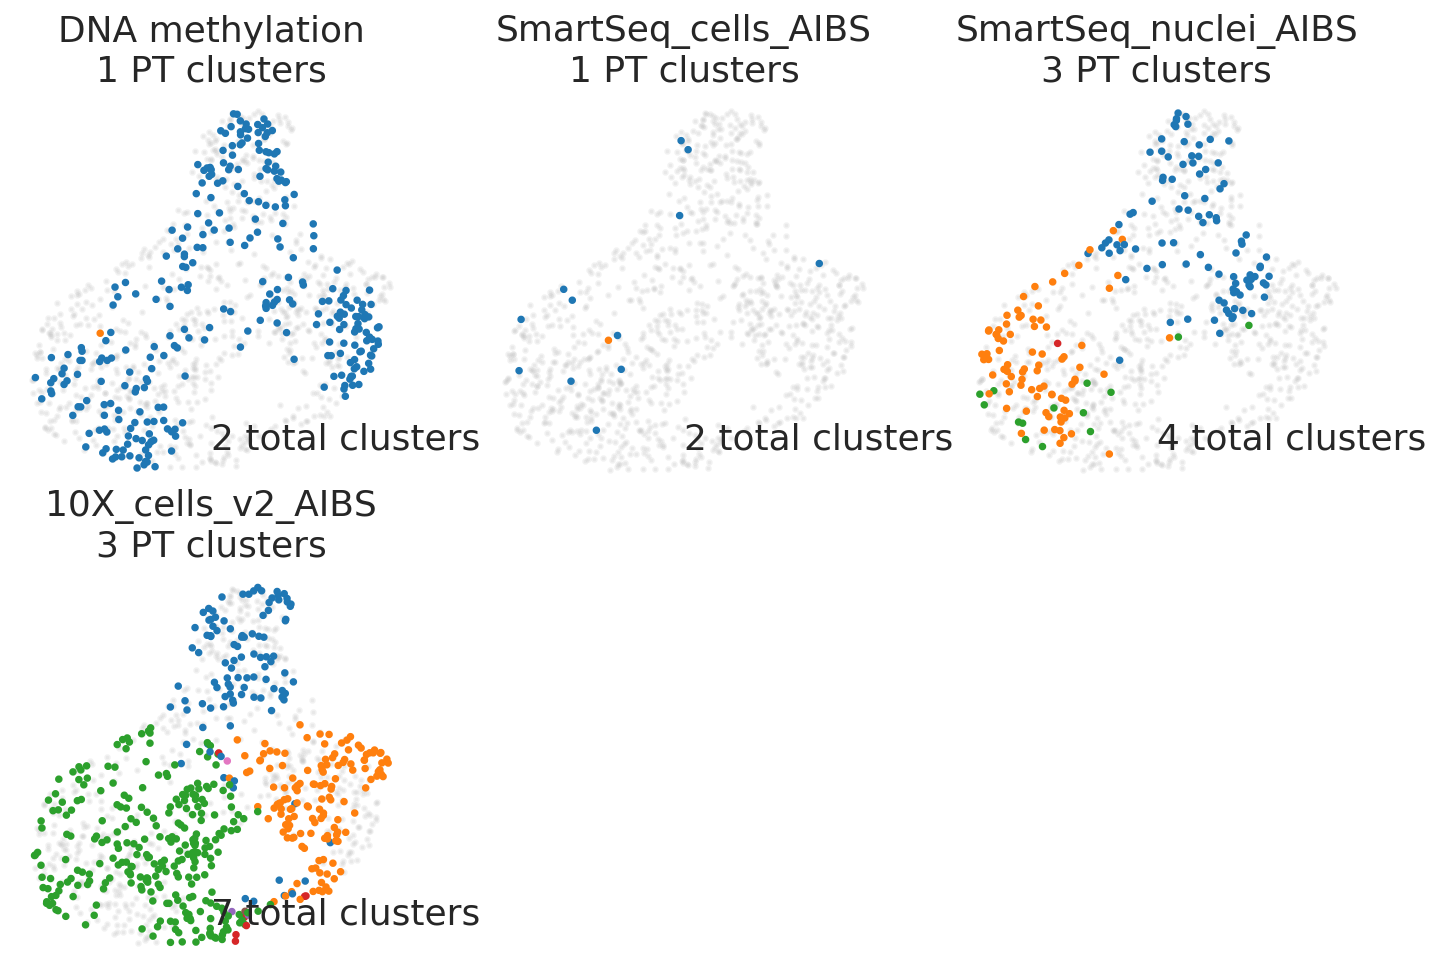

In [13]:
n = len(mods_selected)
nx = 3
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))
axs = axs.flatten()
for mod, ax in zip(mods_ordered, axs):
    ax.scatter(df_info['umap_x_joint'].values, 
                df_info['umap_y_joint'].values, 
                s=3,
                alpha=0.2,
                rasterized=True,
                color='silver')
    tx, ty, tc = 'umap_x_joint', 'umap_y_joint', 'cluster'
    basic_utils.plot_tsne_labels_ax(df_info[df_info['modality']==mod], ax, tx, ty, tc, 
                                      t_xlim=None, t_ylim=None,
                                      legend_mode=-1,
                                      rasterized=True,
                                      s=5,
                                     )
    ax.set_title('{}\n{} PT clusters'.format(settings[mod].name, 
                                          len(df_info.loc[((df_info['modality']==mod) & (pt_cond)), tc].unique()), 
                                         ))
    ax.text(0.5, 0.1, "{} total clusters".format(len(df_info.loc[df_info['modality']==mod, tc].unique())), 
            transform=ax.transAxes,
           )
    ax.axis('off')

for ax in axs[n:]:
    ax.axis('off')

fig.savefig(output_figures.format('plot_4_embedding_by_individual_mod_clusterings', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

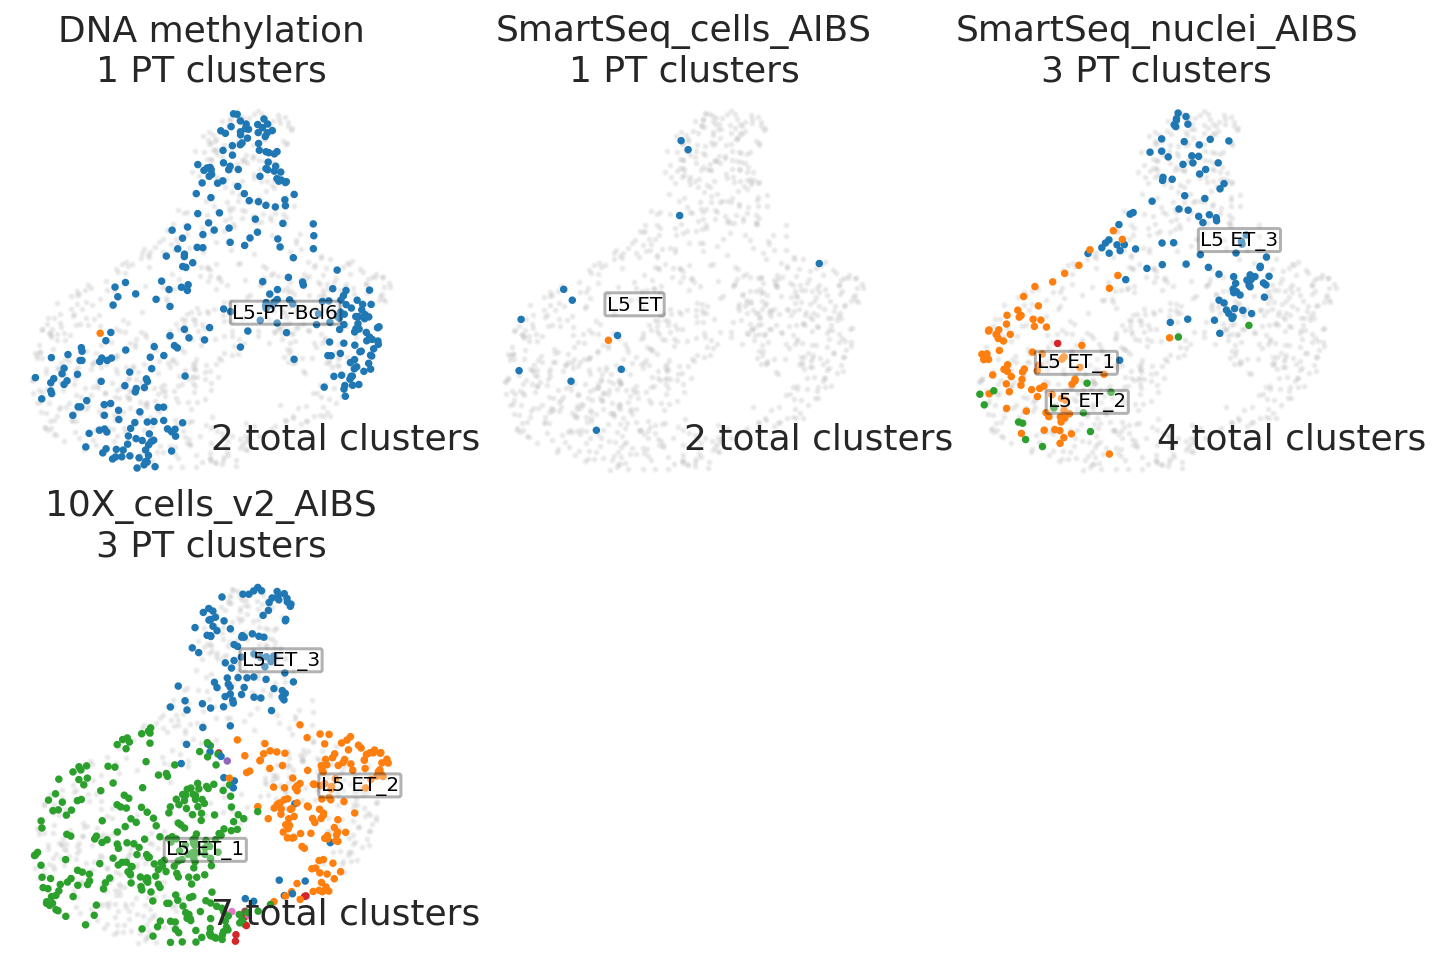

In [14]:
n = len(mods_selected)
nx = 3
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))
axs = axs.flatten()
for mod, ax in zip(mods_ordered, axs):
    ax.scatter(df_info['umap_x_joint'].values, 
                df_info['umap_y_joint'].values, 
                s=3,
                alpha=0.2,
                rasterized=True,
                color='silver')
    tx, ty, tc = 'umap_x_joint', 'umap_y_joint', 'cluster'
    basic_utils.plot_tsne_labels_ax(df_info[df_info['modality']==mod], ax, tx, ty, tc, 
                                      t_xlim=None, t_ylim=None,
                                      legend_mode=-1,
                                      rasterized=True,
                                      s=5,
                                     )
    ax.set_title('{}\n{} PT clusters'.format(settings[mod].name, 
                                          len(df_info.loc[((df_info['modality']==mod) & (pt_cond)), tc].unique()), 
                                         ))
    ax.text(0.5, 0.1, "{} total clusters".format(len(df_info.loc[df_info['modality']==mod, tc].unique())), 
            transform=ax.transAxes,
           )
    ax.axis('off')
    
    for clst, centroid in centroids[mod].iterrows():
        if pt_pattern.match(clst):
            facecolor='white'
            ax.text(centroid.values[0], 
                    centroid.values[1], 
                    clst,
                    color='black', 
                    bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                    fontsize=10,
                   )

for ax in axs[n:]:
    ax.axis('off')

fig.savefig(output_figures.format('plot_5_embedding_by_individual_mod_clusterings_with_labels', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

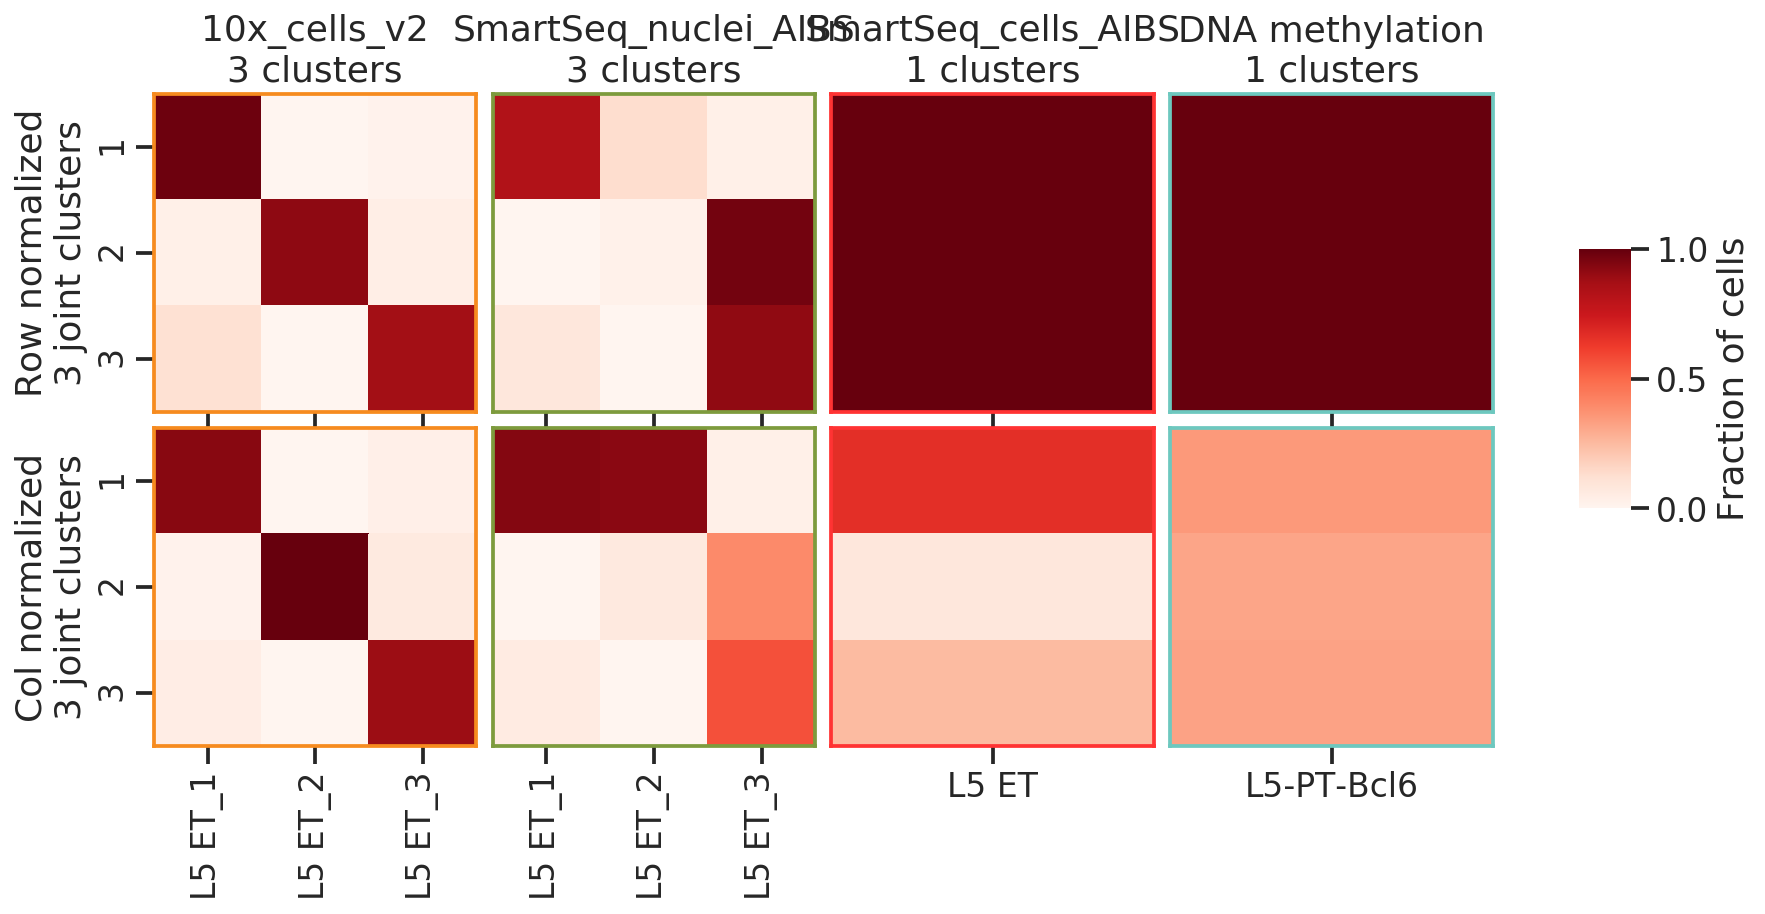

In [15]:
# confusion matrix
nx = len(mods_ordered)
ny = 2
heatmap_kws = {
    'xticklabels': True, 
    'yticklabels': True,
    'vmin': 0, 
    'vmax': 1,
    'cmap': 'Reds',
}

cbar_kws = {
    'orientation': 'vertical', 
    'label': 'Fraction of cells',
}

with sns.plotting_context('talk'):
    fig, axs = plt.subplots(ny, nx, figsize=(3*nx, 3*ny))
    axs = axs.T
    cbar_ax = fig.add_axes([0.95, 0.4, 0.03, 0.3])
    njoint_clusters = len(df_info[joint_cluster].unique())
    for i, (mod, ax) in enumerate(zip(mods_ordered[::-1], axs)):
        conf_mat = pd.crosstab(df_info.loc[((df_info['modality']==mod) & (pt_cond)), 'annot'], 
                               df_info.loc[((df_info['modality']==mod) & (pt_cond)), joint_cluster],
                              )
        # normalize each joint cluster
        conf_mat_njoint = conf_mat.divide(conf_mat.sum(axis=0), axis=1)
        # normalize each orig cluster
        conf_mat_norig = conf_mat.divide(conf_mat.sum(axis=1), axis=0)

        # plot normalized by joint 
        if i == 0:
            # order both row and col
            _X = conf_mat_njoint
            _rX, ri, rc = basic_utils.diag_matrix(_X.values, _X.index.values, _X.columns.values, threshold=0.1)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=True,
                        cbar_kws=cbar_kws,
                        cbar_ax=cbar_ax,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            g.axes.set_title('{}\n{} clusters'.format(mod, _rX.shape[0]))
            g.axes.set_ylabel('Row normalized\n{} joint clusters'.format(njoint_clusters))

            order_joint = _rX.columns.values # Will be fixed for all integrated clusters 
            order_orig = _rX.index.values # Will be fixed for the mod clusters  
        else:
            # order just row (orig)
            _X = conf_mat_njoint.loc[:, order_joint].fillna(0)
            _rX, ri, rc = basic_utils.diag_matrix_rows(_X.values, _X.index.values, _X.columns.values)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=False,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            ax[0].set_yticks([])
            ax[0].set_yticklabels([])
            g.axes.set_title('{}\n{} clusters'.format(settings[mod].name, _rX.shape[0]))
            g.axes.set_ylabel('')

            order_orig = _rX.index.values # Will be fixed for the mod clusters  
        # bounding box
        for _, spine in g.axes.spines.items():
            spine.set_visible(True)
            spine.set_color(settings[mod].color)
#             spine.set_linewidth(3)

        # plot normalized by orig (according to the axis of normalized by joint) 
        _X = conf_mat_norig.loc[order_orig, order_joint].fillna(0)
        g = sns.heatmap(_X.T, 
                    cbar=False,
                    ax=ax[1],
                    **heatmap_kws,
                   )
        
        if i == 0:
            g.axes.set_xlabel('')
            g.axes.set_ylabel('Col normalized\n{} joint clusters'.format(njoint_clusters))
        else:
            ax[1].set_yticks([])
            ax[1].set_yticklabels([])
            g.axes.set_xlabel('')
            g.axes.set_ylabel('')
        # bounding box
        for _, spine in g.axes.spines.items():
            spine.set_visible(True)
            spine.set_color(settings[mod].color)
#             spine.set_linewidth(3)
            
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.savefig(output_figures.format('plot_6_confmat', 'pdf'), bbox_inches='tight')
    plt.show()